In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [4]:
import mynnlib
from mynnlib import *

dataset_dir = "insect-dataset/cicada"

early_regex = r"^.*-(early)$"
unidentified_regex = r"^.*-(spp|genera|genera-spp)$"
early_or_unidentified_regex = r"^.*-(early|spp|genera|genera-spp)$"

# Create Dataset

In [5]:
if os.path.exists(f"{dataset_dir}/data"):
    shutil.rmtree(f"{dataset_dir}/data")
os.makedirs(f"{dataset_dir}/data")

In [6]:
# merge early and imago classes
src_dir = "insect-dataset/src/indiancicadas.org"
for class_dir in os.listdir(src_dir):
    if os.listdir(f"{src_dir}/{class_dir}"):
        if class_dir.endswith("-early"):
            if not os.path.exists(f"{dataset_dir}/data/{re.sub(r"-early", "", class_dir)}"):
                os.makedirs(f"{dataset_dir}/data/{re.sub(r"-early", "", class_dir)}")
            for file in os.listdir(f"{src_dir}/{class_dir}"):
                shutil.copy2(f"{src_dir}/{class_dir}/{file}", f"{dataset_dir}/data/{re.sub(r"-early", "", class_dir)}/{file}")
        else:
            shutil.copytree(f"{src_dir}/{class_dir}", f"{dataset_dir}/data/{class_dir}")

In [7]:
def copy_data_from(sources, add_early=False):
    class_cnt = 0
    img_cnt = 0
    for more_data_dir in sources:
        for class_dir in os.listdir(f"{dataset_dir}/data"):
            if os.path.exists(f"{more_data_dir}/{class_dir}"):
                # print(f"Copying data for {class_dir}...")
                class_cnt += 1
                for file in os.listdir(f"{more_data_dir}/{class_dir}"):
                    shutil.copy2(f"{more_data_dir}/{class_dir}/{file}", f"{dataset_dir}/data/{class_dir}/{file}")
                    img_cnt += 1
            if add_early and os.path.exists(f"{more_data_dir}/{class_dir}-early"):
                # print(f"Copying data for {class_dir}-early...")
                class_cnt += 1
                os.makedirs(f"{dataset_dir}/data/{class_dir}-early/{file}")
                for file in os.listdir(f"{more_data_dir}/{class_dir}-early"):
                    shutil.copy2(f"{more_data_dir}/{class_dir}-early/{file}", f"{dataset_dir}/data/{class_dir}-early/{file}")
                    img_cnt += 1
    print(f"{img_cnt} images added into {class_cnt} classes")

In [8]:
copy_data_from(["insect-dataset/src/inaturalist.org"], add_early=False)

160 images added into 17 classes


# Create val dataset

In [9]:
if not os.path.exists(f"{dataset_dir}/val"):
    os.makedirs(f"{dataset_dir}/val")

In [11]:
move_src = "data"
move_dst = "val"
val_data_ratio = 0.01
val_data_cnt = 0
for class_dir in os.listdir(f"{dataset_dir}/{move_src}"):
    for file in os.listdir(f"{dataset_dir}/{move_src}/{class_dir}"):
        if random.random() < val_data_ratio:
            if not os.path.exists(f"{dataset_dir}/{move_dst}/{class_dir}"):
                os.makedirs(f"{dataset_dir}/{move_dst}/{class_dir}")
            shutil.move(f"{dataset_dir}/{move_src}/{class_dir}/{file}", f"{dataset_dir}/{move_dst}/{class_dir}/")
            val_data_cnt += 1
print(f"{val_data_cnt} images moved from {move_src} to {move_dst}")

16 images moved from data to val


# Count

In [12]:
classes = { class_dir: len([ img for img in os.listdir(f"{dataset_dir}/data/{class_dir}") ]) for class_dir in os.listdir(f"{dataset_dir}/data") }
early_classes = { class_name: count for class_name, count in classes.items() if re.match(early_regex, class_name) }
unidentified_classes = { class_name: count for class_name, count in classes.items() if re.match(unidentified_regex, class_name) }
print(f"Total Class count : {len(classes):6} ( Unidentified: {len(unidentified_classes):6} / Early-stage: {len(early_classes):6} / Identified-adult: {len(classes) - len(unidentified_classes) - len(early_classes):6} )")
print(f"Total  Data count : {sum(classes.values()):6} ( Unidentified: {sum(unidentified_classes.values()):6} / Early-stage: {sum(early_classes.values()):6} / Identified-adult: {sum(classes.values()) - sum(unidentified_classes.values()) - sum(early_classes.values()):6} )")

Total Class count :    162 ( Unidentified:      0 / Early-stage:      0 / Identified-adult:    162 )
Total  Data count :   1163 ( Unidentified:      0 / Early-stage:      0 / Identified-adult:   1163 )


In [13]:
img2_class = []
img5_class = []
for class_dir in os.listdir(f"{dataset_dir}/data"):
    if not re.match(early_or_unidentified_regex, class_dir):
        img_cnt = sum([1 for file in os.listdir(f"{dataset_dir}/data/{class_dir}")])
        img2_class += [class_dir] if img_cnt <= 2 else []
        img5_class += [class_dir] if img_cnt <= 5 else []
print(f"{len(img2_class):6} classes with <=2 images")
print(f"{len(img5_class):6} classes with <=5 images")

    71 classes with <=2 images
    99 classes with <=5 images


In [14]:
generas = set()
for class_name in classes:
    generas.add(class_name.split('-')[0])
print(f"Genera count: {len(generas)}")

Genera count: 55


# Train

### Model A (resnet-50)

In [15]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 5, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 6, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet50", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.cicada.ta.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])

Phase 1:
Epoch    1 /    5  | Train Loss: 4.8136 Acc: 0.0791  | Val Loss: 4.1585 Acc: 0.0625  | Elapsed time: 0:00:30.249098
Epoch    2 /    5  | Train Loss: 3.7449 Acc: 0.2330  | Val Loss: 3.4279 Acc: 0.3750  | Elapsed time: 0:00:49.836342
Epoch    3 /    5  | Train Loss: 2.8777 Acc: 0.4179  | Val Loss: 2.9048 Acc: 0.4375  | Elapsed time: 0:01:09.834152
Epoch    4 /    5  | Train Loss: 2.1791 Acc: 0.5787  | Val Loss: 2.5530 Acc: 0.5000  | Elapsed time: 0:01:29.854198
Epoch    5 /    5  | Train Loss: 1.6544 Acc: 0.6973  | Val Loss: 2.3723 Acc: 0.5625  | Elapsed time: 0:01:49.873551
Phase 2:
Epoch    1 /    5  | Train Loss: 2.3732 Acc: 0.5125  | Val Loss: 2.3386 Acc: 0.5625  | Elapsed time: 0:00:22.036426
Epoch    2 /    5  | Train Loss: 2.0705 Acc: 0.5752  | Val Loss: 2.2414 Acc: 0.6250  | Elapsed time: 0:00:43.917323
Epoch    3 /    5  | Train Loss: 1.8708 Acc: 0.6242  | Val Loss: 2.1982 Acc: 0.6875  | Elapsed time: 0:01:05.954651
Epoch    4 /    5  | Train Loss: 1.8043 Acc: 0.6389  |

In [34]:
model_data = torch.load(f"{dataset_dir}/checkpoint.cicada.ta.ep020002.pth", weights_only=False)

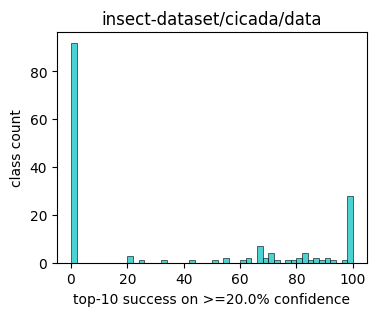

In [35]:
plot_confidence(model_data, f"{dataset_dir}/data", classes, 0.2, k=10)

In [36]:
model_data = torch.load(f"{dataset_dir}/checkpoint.cicada.ta.ep060003.pth", weights_only=False)

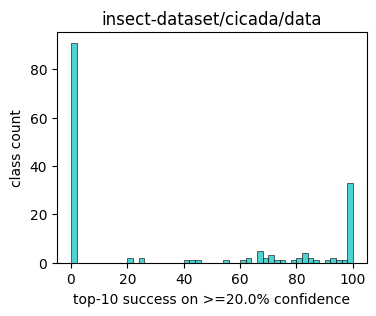

In [37]:
plot_confidence(model_data, f"{dataset_dir}/data", classes, 0.2, k=10)

### Model B (resnet-101)

In [16]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 5, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 6, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet101", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.cicada.tb.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])

Phase 1:
Epoch    1 /    5  | Train Loss: 4.7030 Acc: 0.0954  | Val Loss: 3.8966 Acc: 0.3125  | Elapsed time: 0:00:27.522528
Epoch    2 /    5  | Train Loss: 3.4514 Acc: 0.3044  | Val Loss: 3.1606 Acc: 0.2500  | Elapsed time: 0:00:56.054315
Phase 2:
Epoch    1 /    5  | Train Loss: 3.2667 Acc: 0.3181  | Val Loss: 2.9565 Acc: 0.3125  | Elapsed time: 0:00:28.524959
Epoch    2 /    5  | Train Loss: 2.8330 Acc: 0.4230  | Val Loss: 2.8025 Acc: 0.4375  | Elapsed time: 0:00:58.412254
Epoch    3 /    5  | Train Loss: 2.5021 Acc: 0.4858  | Val Loss: 2.5644 Acc: 0.5000  | Elapsed time: 0:01:27.914481
Epoch    4 /    5  | Train Loss: 2.2584 Acc: 0.5314  | Val Loss: 2.5057 Acc: 0.5625  | Elapsed time: 0:01:57.435651
Epoch    5 /    5  | Train Loss: 2.0773 Acc: 0.5778  | Val Loss: 2.4956 Acc: 0.5625  | Elapsed time: 0:02:27.553085
Phase 3:
Epoch    1 /    5  | Train Loss: 1.9816 Acc: 0.5967  | Val Loss: 2.2928 Acc: 0.5625  | Elapsed time: 0:00:28.750290
Epoch    2 /    5  | Train Loss: 1.9089 Acc: 

In [38]:
model_data = torch.load(f"{dataset_dir}/checkpoint.cicada.tb.ep050000.pth", weights_only=False)

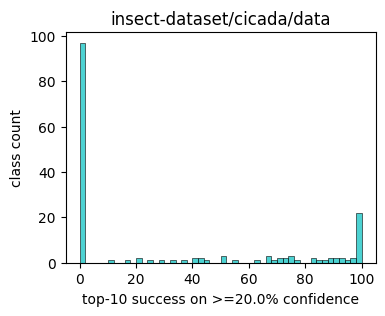

In [39]:
plot_confidence(model_data, f"{dataset_dir}/data", classes, 0.2, k=10)

### Model C (resnet-34)

In [17]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 5, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 6, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet34", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.cicada.tc.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])

Phase 1:
Epoch    1 /    5  | Train Loss: 4.4672 Acc: 0.1470  | Val Loss: 3.7088 Acc: 0.1875  | Elapsed time: 0:00:15.842481
Epoch    2 /    5  | Train Loss: 2.7860 Acc: 0.4402  | Val Loss: 3.0062 Acc: 0.3750  | Elapsed time: 0:00:31.149213
Epoch    3 /    5  | Train Loss: 1.9287 Acc: 0.6741  | Val Loss: 2.6723 Acc: 0.5625  | Elapsed time: 0:00:46.746422
Epoch    4 /    5  | Train Loss: 1.3336 Acc: 0.8186  | Val Loss: 2.4934 Acc: 0.5000  | Elapsed time: 0:01:02.424913
Phase 2:
Epoch    1 /    5  | Train Loss: 2.4823 Acc: 0.4875  | Val Loss: 2.5548 Acc: 0.5000  | Elapsed time: 0:00:17.214553
Epoch    2 /    5  | Train Loss: 2.1617 Acc: 0.5503  | Val Loss: 2.4588 Acc: 0.4375  | Elapsed time: 0:00:34.442380
Phase 3:
Epoch    1 /    5  | Train Loss: 2.0587 Acc: 0.5864  | Val Loss: 2.5163 Acc: 0.3750  | Elapsed time: 0:00:17.221948
Epoch    2 /    5  | Train Loss: 1.8502 Acc: 0.6268  | Val Loss: 2.3477 Acc: 0.4375  | Elapsed time: 0:00:34.732110
Epoch    3 /    5  | Train Loss: 1.7571 Acc: 